# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import regex as re
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## Download wordnet

In [2]:
import nltk

print("Downloading NLTK 'wordnet' corpus...")
nltk.download('wordnet')
print("Download complete.")

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


Download complete.


# Download the CSV files from S3 bucket 

In [3]:
import boto3
import pandas as pd
from io import StringIO

s3 = boto3.client("s3")
bucket = "lazycat-reddit-data-storage"
prefix = "reddit-cleaned/"

# List objects
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

dfs = []
for obj in response.get("Contents", []):
    if obj["Key"].endswith(".csv"):
        file_obj = s3.get_object(Bucket=bucket, Key=obj["Key"])
        df = pd.read_csv(StringIO(file_obj["Body"].read().decode("utf-8")))
        dfs.append(df)

#### I downloaded two csv files from an external storage, and they have a different format, so I'm combining them here at the bottom.

In [4]:
combined_df1 = pd.concat([dfs[0], dfs[1]], ignore_index=True)
combined_df2 = pd.concat([dfs[2], dfs[3]], ignore_index=True)

In [5]:
combined_df2['subreddit'] = combined_df2['subreddit'].map({'TheOnion': 1, 'Conspiracy': 0})

In [6]:
combined_df2.head()

,id,subreddit,title
0,1k3ks1v,0,Sol Invictus
1,1k3kqez,0,All Reddit posts as proof of five consecutive ...
2,1k3kbyy,0,Hell is just a server
3,1k3k09g,0,The 160 abandoned Malagasy- A terrifying story...
4,1k3jspd,0,'Vaccines' could well have been necessary to s...


In [7]:
df = combined_df1.append(combined_df2)

/tmp/ipykernel_7814/3585711790.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = combined_df1.append(combined_df2)


In [8]:
df.shape

(3844, 4)

In [9]:
df.dtypes

Unnamed: 0    float64
id             object
subreddit       int64
title          object
dtype: object

In [10]:
df.reset_index(inplace = True,drop = True)

In [11]:
df.dtypes

Unnamed: 0    float64
id             object
subreddit       int64
title          object
dtype: object

In [12]:
df.to_csv('./combined_data2.csv')

## Exploratory Data Analysis

### First, let's separate the data by subreddits

In [13]:
df_onion = df[df['subreddit'] == 1].copy()
df_onion.drop_duplicates(subset = 'id',inplace = True)
df_onion.shape

(1075, 4)

In [14]:
df_conspiracy = df[df['subreddit'] == 0].copy()
df_conspiracy.drop_duplicates(subset = 'id',inplace = True)
df_conspiracy.shape

(1744, 4)

### Tokenizing & Lemmatizing Data

In [15]:
def tokenize_lemmatize(text_col):
    # Instantiate tokenizer
    tokenizer = RegexpTokenizer(r'[A-z]+')
    
    # Tokenize text
    tokens = [tokenizer.tokenize(post.lower()) for post in text_col]
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens_lem = []
    # lemmatize words
    for words in tokens:
        lem_list = [lemmatizer.lemmatize(i) for i in words]
        lem_post = ''
        for word in lem_list:
            lem_post += (word+' ')
        tokens_lem.append(lem_post.strip())
    
    return (tokens_lem)

In [16]:
lemma_token_list = tokenize_lemmatize(df_onion['title'])

In [17]:
lemma_token_list[2]

'coming clean the world s orchestra conductor have come together to admit their job is a easy and fun a it look'

In [18]:
cvec = CountVectorizer()
lemma_features = cvec.fit_transform(lemma_token_list)

In [19]:
vocab = cvec.get_feature_names_out()
print(vocab)

['aaron' 'abandoned' 'abandoning' ... 'zoo' 'zookeeper' 'zuckerberg']


##### Find frequently used words

In [20]:
def term_counts(df, stop_list = None,n_gram = (1,1)):
    
    # Count Vectorize
    cvec = CountVectorizer(stop_words = stop_list,ngram_range= n_gram)
    title_cvec = pd.DataFrame(cvec.fit_transform(df['title']).toarray(),
                          columns = cvec.get_feature_names_out())

    # See word counts
    counts = title_cvec.sum().sort_values(0, ascending=False)
    
    return counts

# r/TheOnion

/tmp/ipykernel_7814/3657098408.py:9: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  counts = title_cvec.sum().sort_values(0, ascending=False)


Text(0, 0.5, 'Words')

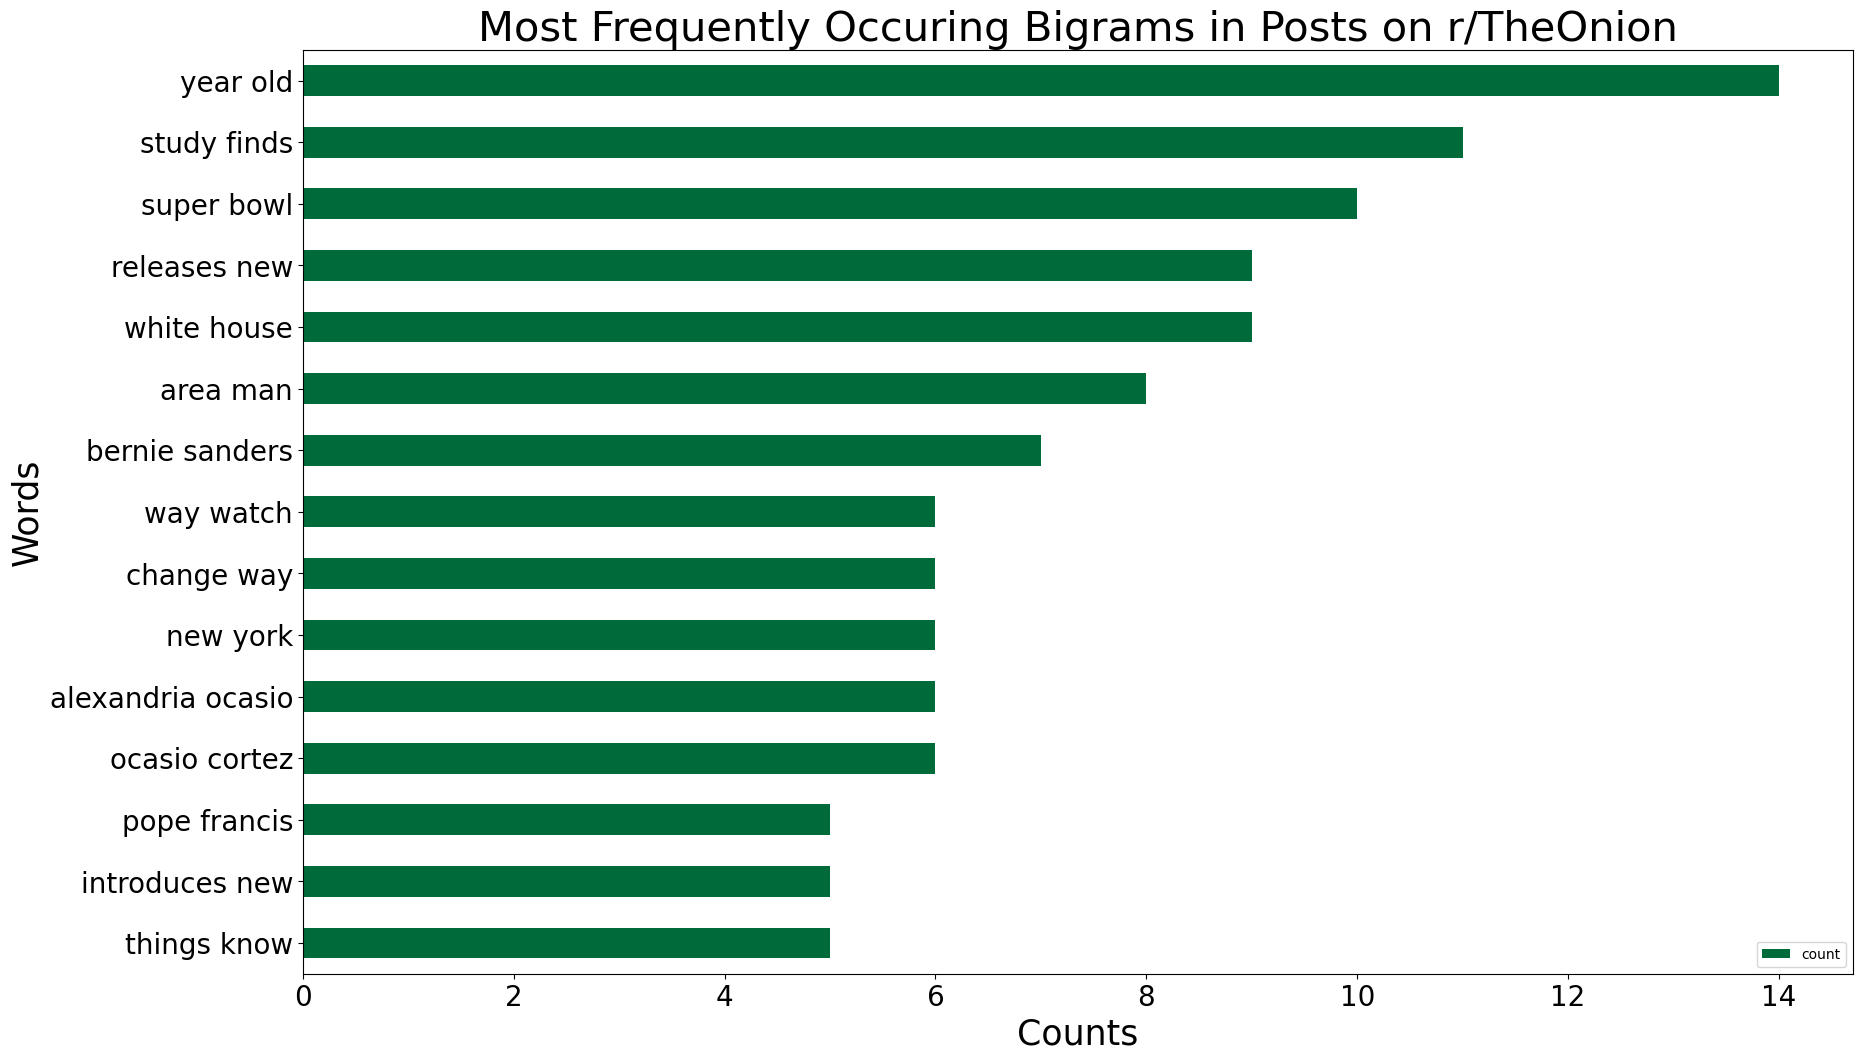

In [21]:
onion_bigram_counts = pd.DataFrame(term_counts(df = df_onion,n_gram=(2,2),stop_list = 'english'), columns=["count"])

onion_top_bigrams = onion_bigram_counts.head(15).sort_values(by = 'count',ascending = True)
onion_top_bigrams.plot(kind = 'barh',figsize=(20,12),color = '#006b3a',fontsize=20)
plt.title('Most Frequently Occuring Bigrams in Posts on r/TheOnion',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Words', size = 25)
#plt.figtext(.4,.4,f'Number of Unique Bigrams: {len(onion_bigram_counts)}')

##### no stop words

In [22]:

cvec = CountVectorizer()
# Fit our CountVectorizer on the training data and transform training data.
onion_cvec = pd.DataFrame(cvec.fit_transform(df_onion['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Words: {onion_cvec.shape[1]}')
onion_cvec.sum()[onion_cvec.sum() >= 25].sort_values(ascending = False)

Number of Unique Words: 4771


to        407
of        340
the       246
in        182
for       151
on        114
this      104
and       103
he        101
it         86
new        86
that       85
with       82
by         77
has        69
man        69
at         66
his        61
just       60
after      60
what       60
you        58
they       57
is         57
be         56
trump      50
as         48
from       47
said       45
who        44
out        44
about      43
will       42
up         41
all        39
into       38
report     37
have       37
not        36
was        33
your       32
year       31
like       31
her        29
off        28
him        28
can        28
how        27
if         27
an         27
woman      27
time       27
now        27
old        26
over       26
day        25
one        25
when       25
dtype: int64

#### bigrams, no stop words

In [23]:
cvec = CountVectorizer(ngram_range=(2,2))
# Fit our CountVectorizer on the training data and transform training data.
onion_bigram_cvec = pd.DataFrame(cvec.fit_transform(df_onion['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Bigrams: {onion_bigram_cvec.shape[1]}')
onion_bigram_cvec.sum()[onion_bigram_cvec.sum()>=10].sort_values(ascending = False)

Number of Unique Bigrams: 10805


said what      44
of the         25
to be          15
in the         15
year old       14
out of         12
for the        11
study finds    11
to get         11
super bowl     10
to give        10
will be        10
dtype: int64

<Axes: >

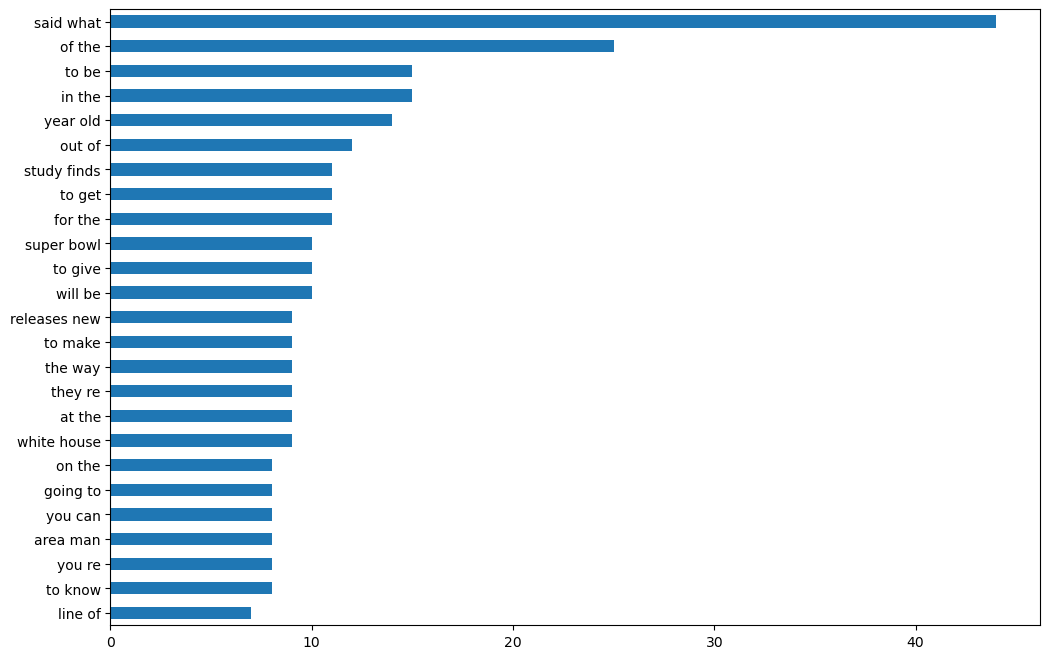

In [24]:
onion_bigram_cvec_top = onion_bigram_cvec.sum().sort_values(ascending = True).tail(25)
onion_bigram_cvec_top.plot(kind = 'barh',figsize=(12,8))

#### stop words = english

In [25]:
cvec = CountVectorizer(stop_words='english')
# Fit our CountVectorizer on the training data and transform training data.
onion_cvec_stop = pd.DataFrame(cvec.fit_transform(df_onion['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Words: {onion_cvec_stop.shape[1]}')
onion_cvec_stop.sum()[onion_cvec_stop.sum() >= 20].sort_values(ascending = False)

Number of Unique Words: 4554


new       86
man       69
just      60
trump     50
said      45
report    37
year      31
like      31
woman     27
time      27
old       26
day       25
nation    24
people    22
know      21
life      21
kids      21
family    20
way       20
dtype: int64

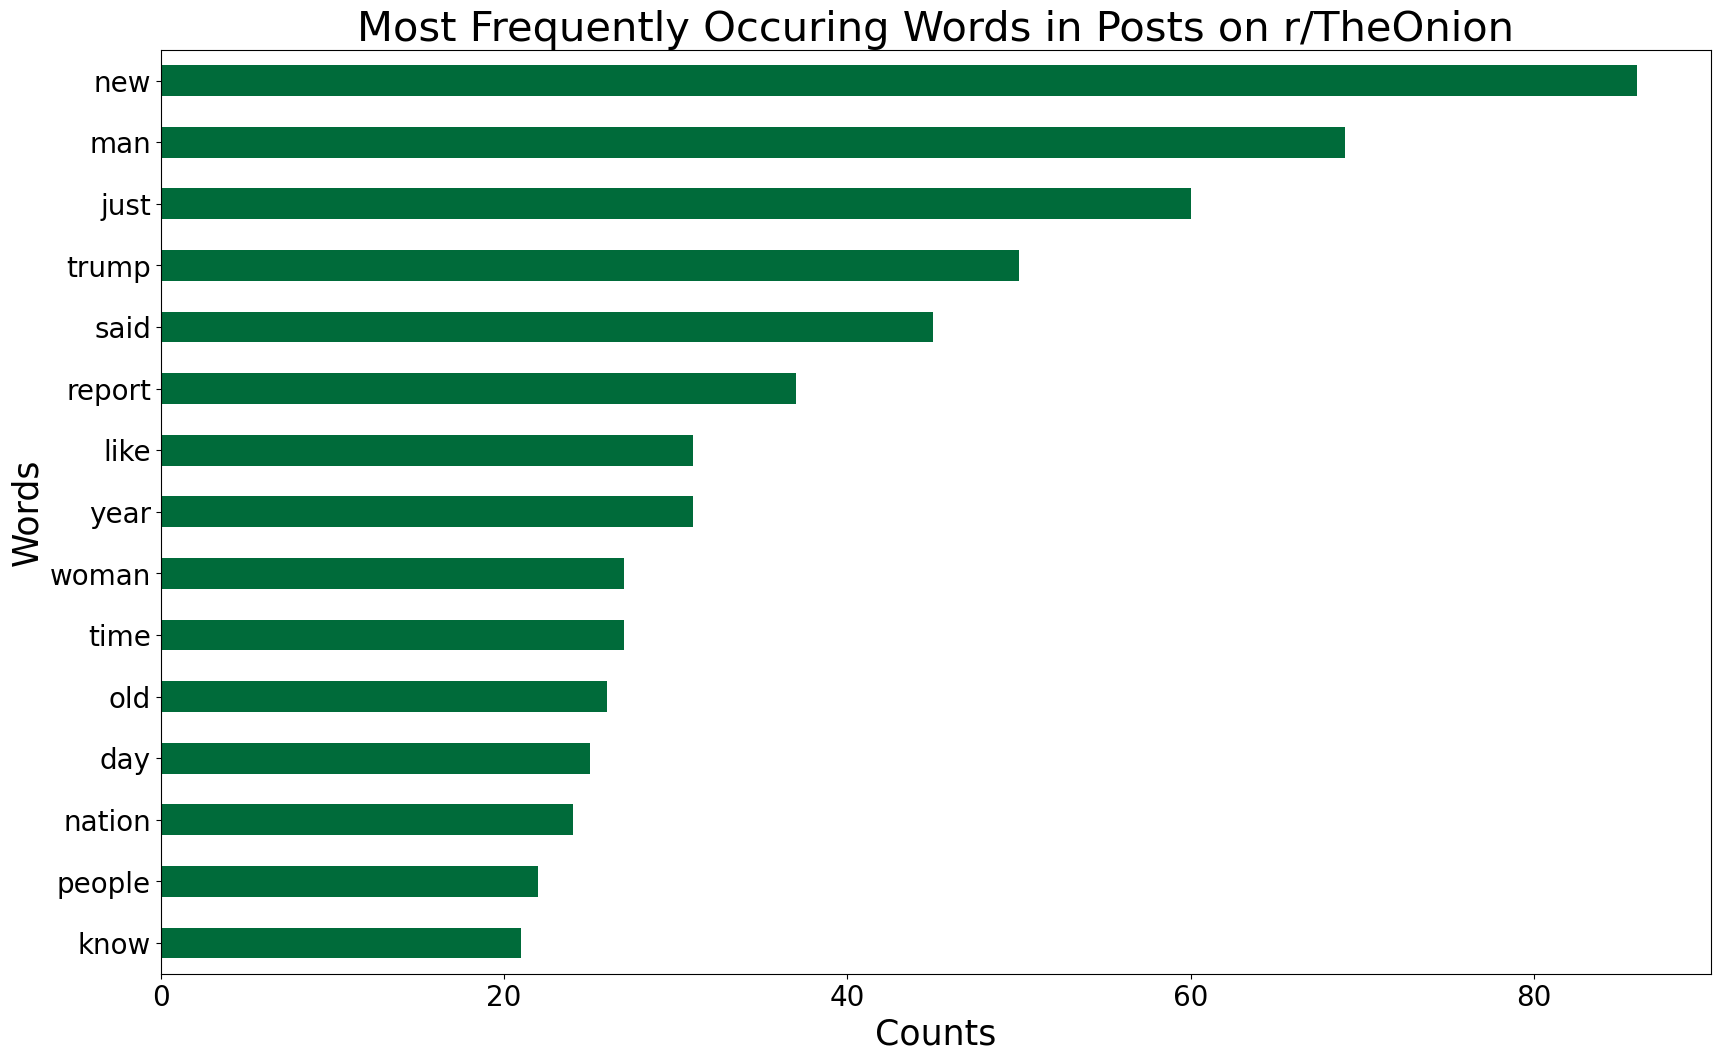

In [26]:
onion_cvec_stop_top = onion_cvec_stop.sum().sort_values(ascending = True).tail(15)
onion_cvec_stop_top.plot(kind = 'barh',figsize=(20,12),color = '#006b3a',fontsize=20)
plt.title('Most Frequently Occuring Words in Posts on r/TheOnion',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Words', size = 25);

#### bigrams, stop words = english

/tmp/ipykernel_7814/3657098408.py:9: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  counts = title_cvec.sum().sort_values(0, ascending=False)


Text(0, 0.5, 'Words')

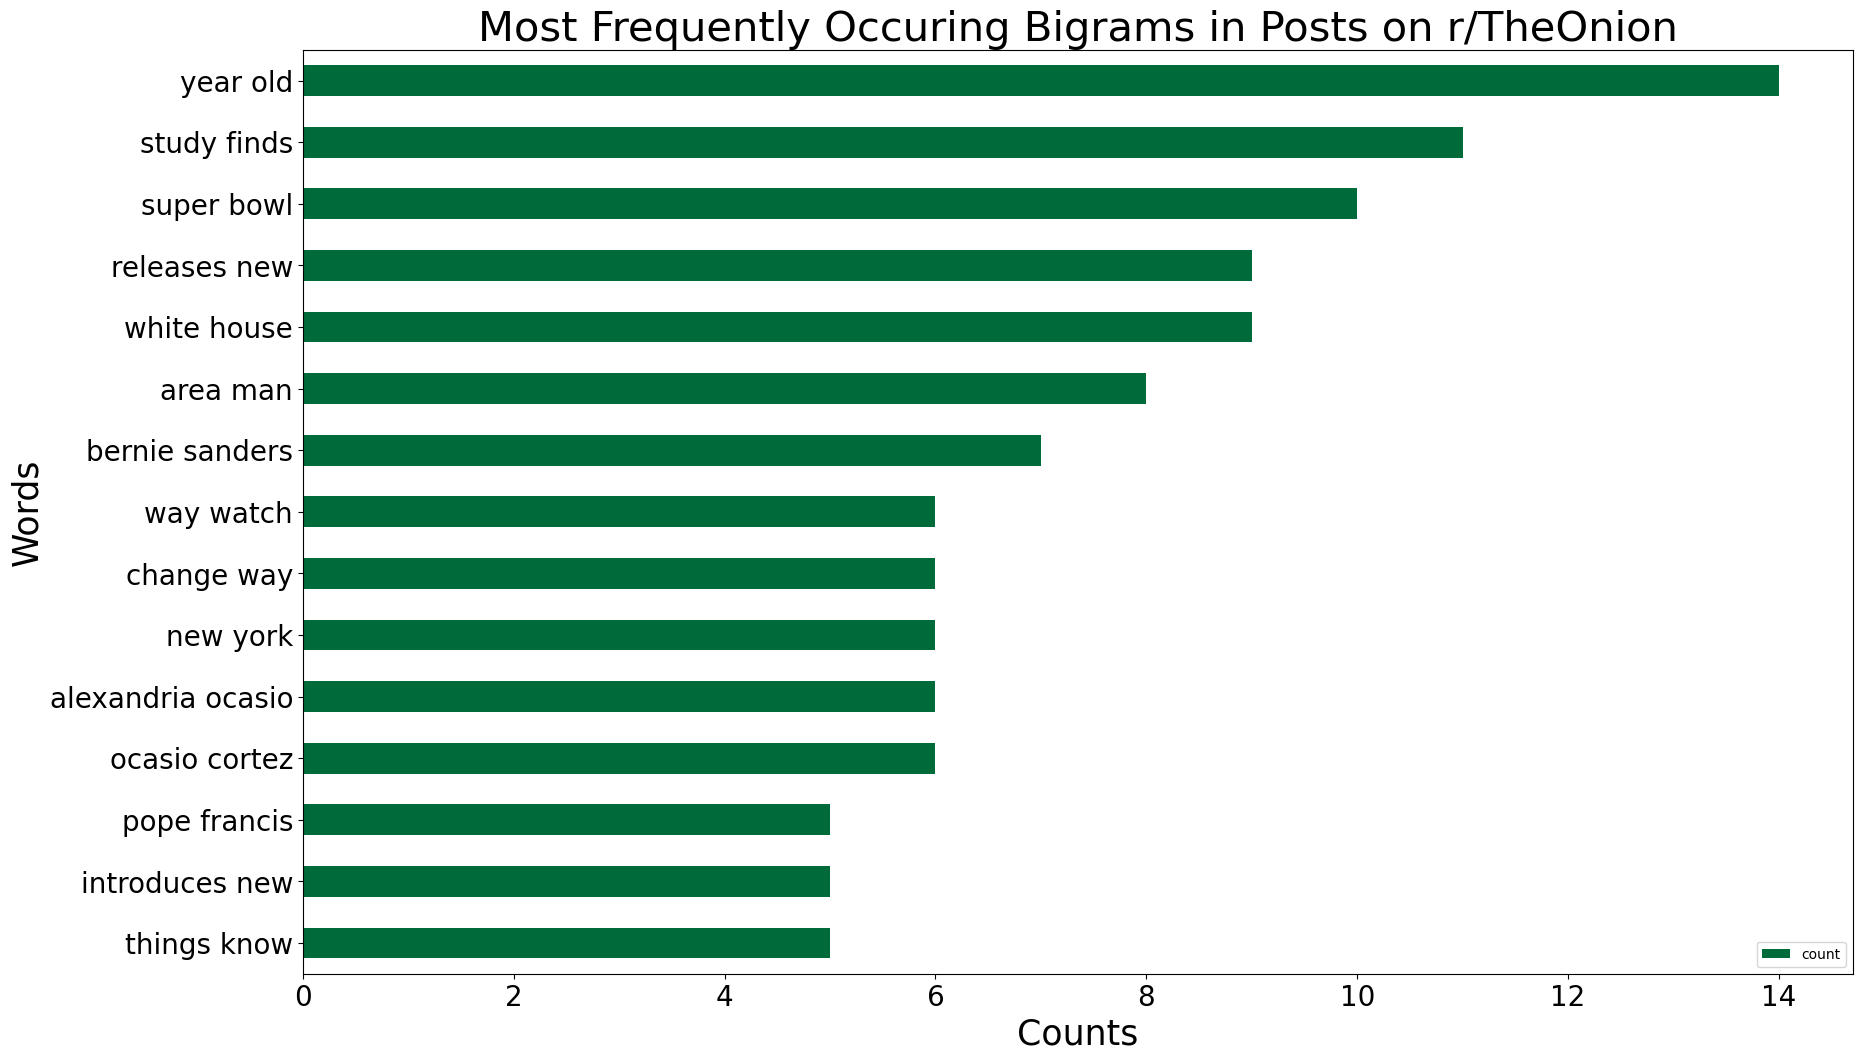

In [27]:
onion_bigram_counts = pd.DataFrame(term_counts(df = df_onion,n_gram=(2,2),stop_list = 'english'), columns=["count"])

onion_top_bigrams = onion_bigram_counts.head(15).sort_values(by = 'count',ascending = True)
onion_top_bigrams.plot(kind = 'barh',figsize=(20,12),color = '#006b3a',fontsize=20)
plt.title('Most Frequently Occuring Bigrams in Posts on r/TheOnion',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Words', size = 25)
#plt.figtext(20,20,s = f'Number of Unique Bigrams: {len(onion_top_bigrams)}');

In [28]:
cvec = CountVectorizer(stop_words='english',ngram_range=(2,2))
# Fit our CountVectorizer on the training data and transform training data.
onion_bigram_cvec_stop = pd.DataFrame(cvec.fit_transform(df_onion['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Bigrams: {onion_bigram_cvec_stop.shape[1]}')
onion_bigram_cvec_stop.sum()[onion_bigram_cvec_stop.sum() >= 5].sort_values(ascending = False)

Number of Unique Bigrams: 7400


year old             14
study finds          11
super bowl           10
releases new          9
white house           9
area man              8
bernie sanders        7
alexandria ocasio     6
change way            6
way watch             6
ocasio cortez         6
new york              6
pope francis          5
introduces new        5
roger stone           5
things know           5
dtype: int64

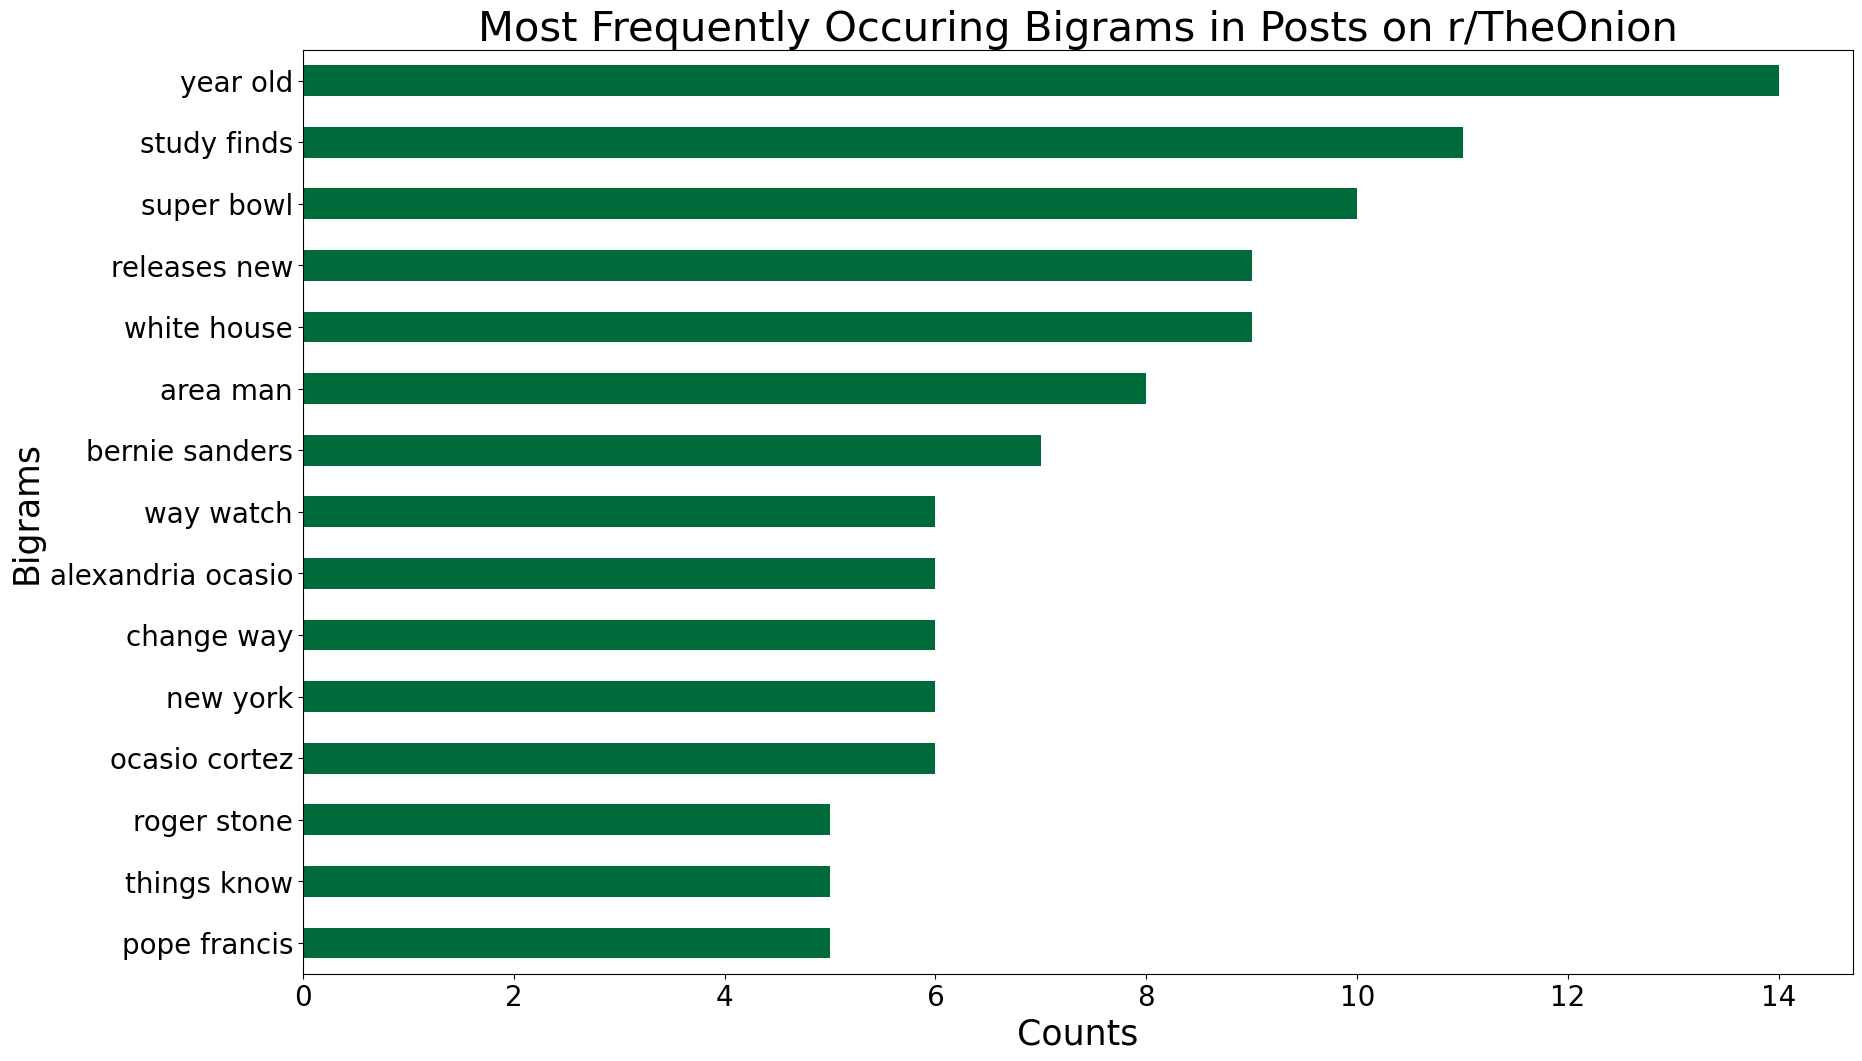

In [29]:
onion_bigram_cvec_stop_top = onion_bigram_cvec_stop.sum().sort_values(ascending = True).tail(15)
onion_bigram_cvec_stop_top.plot(kind = 'barh',figsize=(20,12),color = '#006b3a',fontsize=20)
plt.title('Most Frequently Occuring Bigrams in Posts on r/TheOnion',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Bigrams', size = 25);

# r/Conspiracy

In [30]:
# Instantiate CountVectorizer
cvec = CountVectorizer()
# Fit CountVectorizer on the training data and transform training data.
conspiracy_cvec = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Words: {conspiracy_cvec.shape[1]}')
conspiracy_cvec.sum()[conspiracy_cvec.sum() >= 25].sort_values(ascending = False)

Number of Unique Words: 6223


the        1241
to          655
of          618
and         473
is          415
           ... 
does         26
other        25
history      25
state        25
here         25
Length: 118, dtype: int64

#### no stop words

In [31]:
# Instantiate CountVectorizer
cvec = CountVectorizer()
# Fit CountVectorizer on the training data and transform training data.
conspiracy_cvec = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Words: {conspiracy_cvec.shape[1]}')
conspiracy_cvec.sum()[conspiracy_cvec.sum() >= 25].sort_values(ascending = False)

Number of Unique Words: 6223


the        1241
to          655
of          618
and         473
is          415
           ... 
does         26
other        25
history      25
state        25
here         25
Length: 118, dtype: int64

#### bigram, no stop words

In [32]:
# Instantiate CountVectorizer
cvec = CountVectorizer(ngram_range=(2,2))
# Fit CountVectorizer on the training data and transform training data.
conspiracy_bigram_cvec = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Bigrams: {conspiracy_bigram_cvec.shape[1]}')
conspiracy_bigram_cvec.sum()[conspiracy_bigram_cvec.sum() >= 9].sort_values(ascending = False)

Number of Unique Bigrams: 19263


of the       116
in the        84
on the        51
is the        37
to the        37
            ... 
right now      9
if the         9
if you         9
dr sebi        9
used to        9
Length: 77, dtype: int64

#### stop words = english

In [33]:
cvec = CountVectorizer(stop_words='english')
# Fit our CountVectorizer on the training data and transform training data.
conspiracy_cvec_stop = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Words: {conspiracy_cvec_stop.shape[1]}')
conspiracy_cvec_stop.sum()[conspiracy_cvec_stop.sum() >= 20].sort_values(ascending = False)

Number of Unique Words: 5991


trump         94
conspiracy    92
people        86
new           60
just          55
              ..
old           20
say           20
reddit        20
secret        20
actually      20
Length: 69, dtype: int64

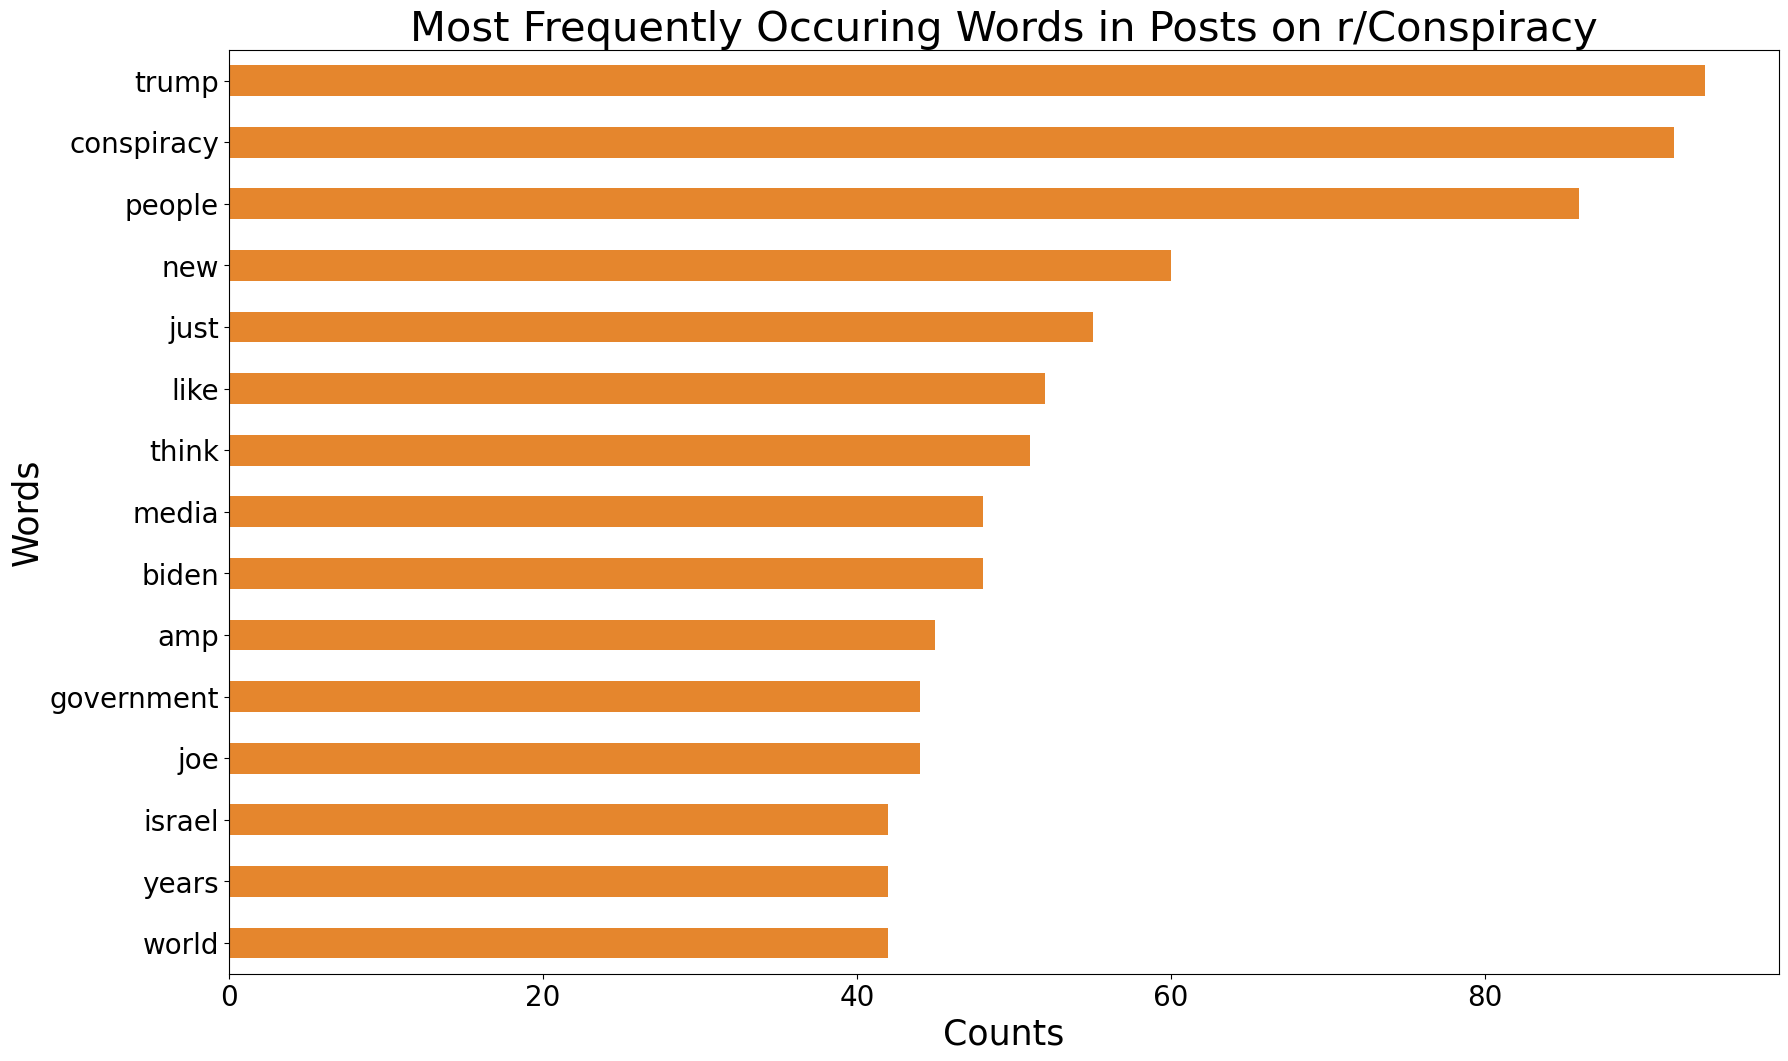

In [34]:
conspiracy_cvec_stop_top = conspiracy_cvec_stop.sum().sort_values(ascending = True).tail(15)
conspiracy_cvec_stop_top.plot(kind = 'barh',figsize=(20,12),color = '#e5862d',fontsize=20)
plt.title('Most Frequently Occuring Words in Posts on r/Conspiracy',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Words', size = 25);

#### bigrams, stop_words=english

In [35]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words = 'english',ngram_range=(2,2))
# Fit CountVectorizer on the training data and transform training data.
conspiracy_bigram_cvec_stop = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
print(f'Number of Unique Bigrams: {conspiracy_bigram_cvec_stop.shape[1]}')
conspiracy_bigram_cvec_stop.sum()[conspiracy_bigram_cvec_stop.sum() >= 5].sort_values(ascending = False)

Number of Unique Bigrams: 12914


joe biden                29
sandy hook               28
jussie smollett          24
nipsey hussle            22
alex jones               21
donald trump             13
julian assange           12
mueller report           12
new zealand              11
dr sebi                   9
smollett case             9
article 13                9
conspiracy theory         9
conspiracy theories       9
year old                  9
deep state                8
president trump           8
tulsi gabbard             8
united states             8
years ago                 8
new york                  8
rapper nipsey             7
social media              7
joe rogan                 7
golan heights             7
kim foxx                  7
chan thomas               7
eve story                 6
charges dropped           6
jimmy dore                6
white house               6
mainstream media          6
chicago pd                6
adam eve                  5
friendly reminder         5
false flag          

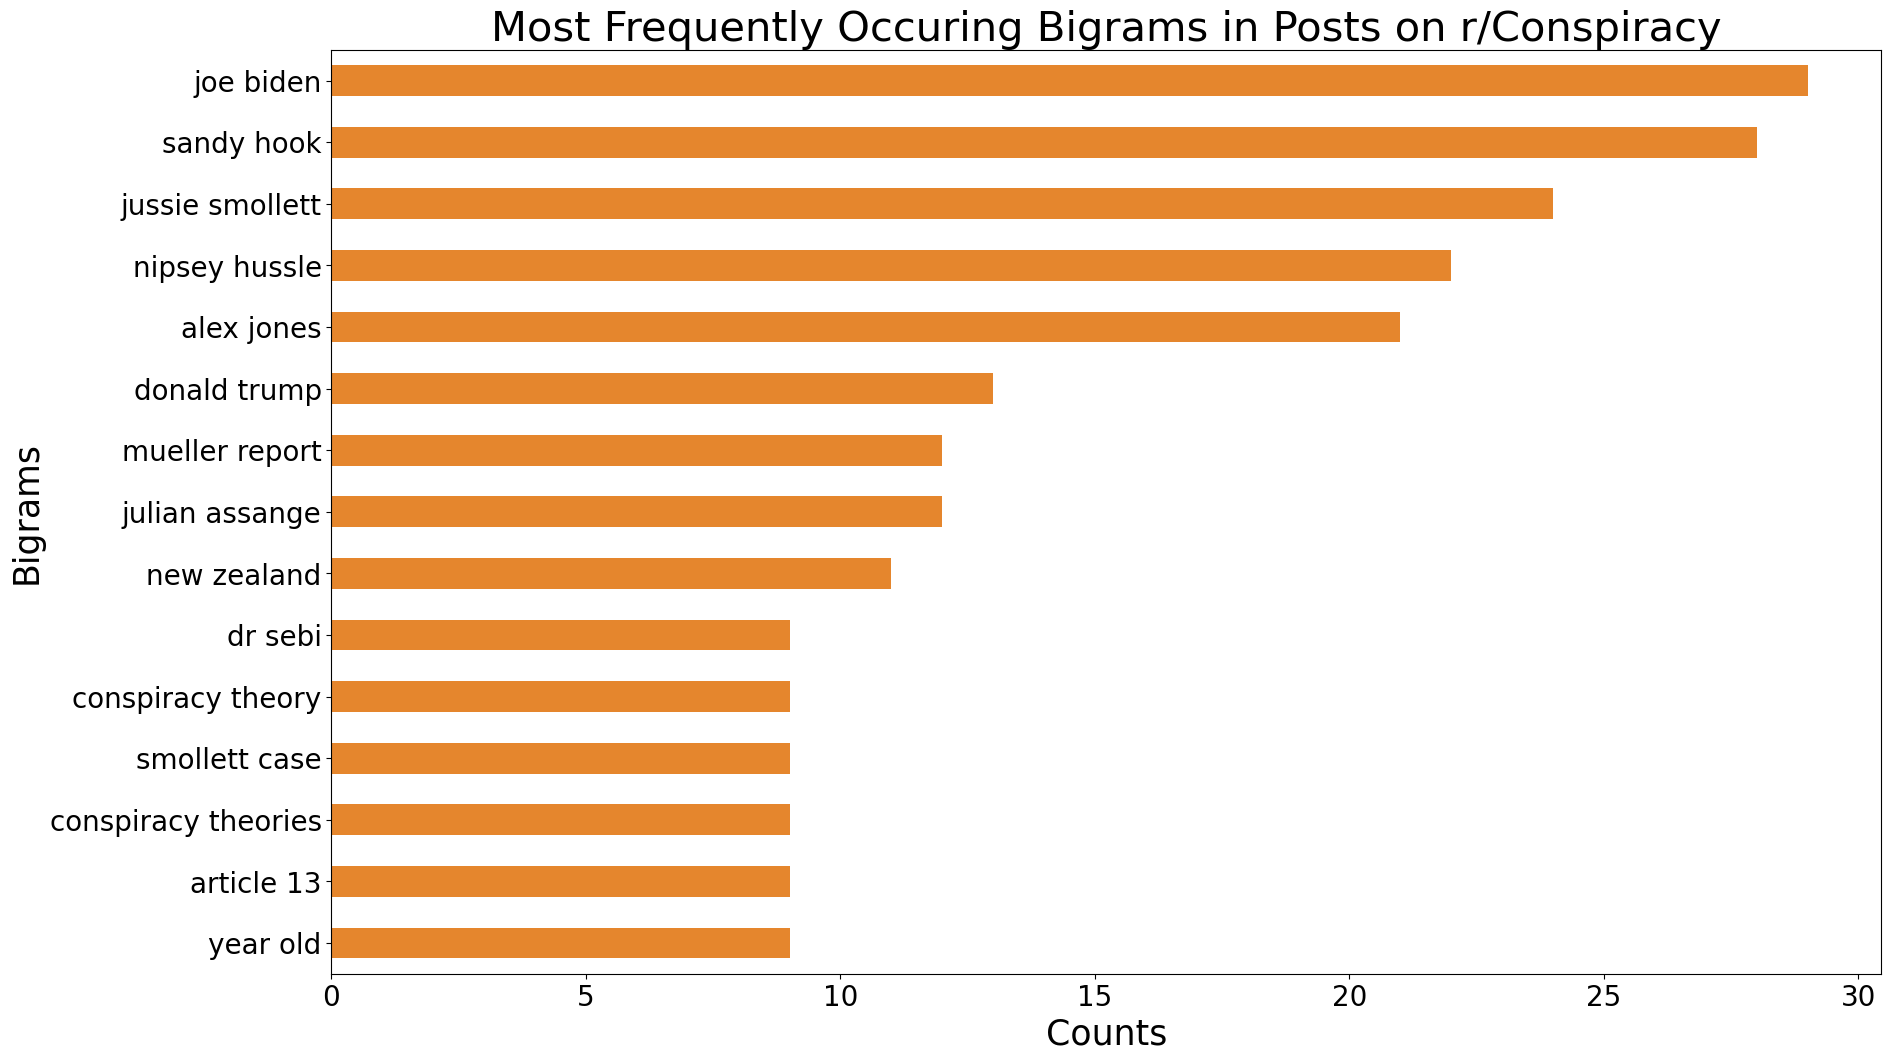

In [36]:
conspiracy_bigram_cvec_stop_top = conspiracy_bigram_cvec_stop.sum().sort_values(ascending = True).tail(15)
conspiracy_bigram_cvec_stop_top.plot(kind = 'barh',figsize=(20,12),color = '#e5862d',fontsize=20)
plt.title('Most Frequently Occuring Bigrams in Posts on r/Conspiracy',size = 30)
plt.xlabel('Counts', size = 25)
plt.ylabel('Bigrams', size = 25);

## All common words in Posts

In [37]:
# Find all common words in TheOnion and Conspiracy Posts
common_words = []
for i in list(onion_cvec_stop):
    for j in list(conspiracy_cvec_stop):
        if i == j:
            common_words.append(i)

In [38]:
len(common_words)

1939

### create list of tstop words to both subreddits

In [39]:
stop_english_common = text.ENGLISH_STOP_WORDS.union(common_words)


In [40]:
stop_words_list = list(stop_english_common)
cvec = CountVectorizer(stop_words=stop_words_list)
# Fit our CountVectorizer on the training data and transform training data.
conspiracy_cvec_stop_en_com = pd.DataFrame(cvec.fit_transform(df_conspiracy['title']).todense(),
                          columns = cvec.get_feature_names_out())
conspiracy_cvec_stop_en_com.sum()[conspiracy_cvec_stop_en_com.sum()>9].sort_values(ascending = False)

conspiracy      92
fbi             39
nipsey          35
sandy           28
hussle          24
truth           23
assange         23
alex            21
reddit          20
vaccine         20
vaccines        19
propaganda      19
russiagate      18
5g              18
theories        16
google          15
information     15
political       15
eu              14
ancient         14
proof           14
justice         14
false           14
russian         14
clinton         13
april           13
julian          13
hoax            13
technology      13
wikileaks       12
jewish          12
videos          12
climate         12
collusion       12
christchurch    12
embassy         12
measles         12
unvaccinated    12
conspiracies    11
tulsi           11
zealand         11
medical         11
sub             11
nxivm           11
illuminati      10
hillary         10
meta            10
msm             10
paid            10
thoughts        10
uk              10
vs              10
dtype: int64

In [41]:
cvec = CountVectorizer(stop_words=stop_words_list)
# Fit our CountVectorizer on the training data and transform training data.
onion_cvec_stop_en_com = pd.DataFrame(cvec.fit_transform(df_onion['title']).todense(),
                          columns = cvec.get_feature_names_out())
onion_cvec_stop_en_com.sum()[onion_cvec_stop_en_com.sum()>=5].sort_values(ascending = False)

beautiful        12
onion            11
ftw              10
teen             10
bowl             10
dad               9
fans              7
happy             7
heartbreaking     7
introduces        7
ep                7
drive             7
awesome           7
roger             7
rowling           7
owner             6
unveils           6
tom               6
issues            6
grandmother       6
francis           6
bezos             6
christmas         6
stone             6
heartwarming      6
fan               6
announce          5
apartment         5
basketball        5
absolutely        5
character         5
bottle            5
bag               5
mountain          5
hard              5
horrified         5
hare              5
holiday           5
realizing         5
quit              5
okay              5
oscars            5
normal            5
smoking           5
singer            5
sleep             5
dtype: int64

In [42]:
df.drop_duplicates(subset = 'id',inplace = True)
df.reset_index(inplace = True,drop = True)
df.shape

(2819, 4)

In [43]:
# export dataset
df.to_csv('dataset.csv')

# Modeling

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,recall_score,precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [45]:
X = df['title']
y = df['subreddit']

In [46]:
y.value_counts(normalize = True)

0    0.618659
1    0.381341
Name: subreddit, dtype: float64

In [47]:
vectorizer = [CountVectorizer(), TfidfVectorizer()]
classifier = [KNeighborsClassifier(),LogisticRegression(), MultinomialNB(), RandomForestClassifier()]
vec_param = { 'CountVectorizer': { 
                                    'CountVectorizer__max_features': [None,1200,2000,2250,3500],
                                    'CountVectorizer__min_df': [2,3,4],
                                    'CountVectorizer__max_df': [.3,.35,.4,.5],
                                    'CountVectorizer__ngram_range': [(1,1),(1,2)],
                                    'CountVectorizer__stop_words': [None,'english']
                                    },
               'TfidfVectorizer': {
                                    'TfidfVectorizer__max_features': [None,1200,2000,2250,3500],
                                    'TfidfVectorizer__min_df': [2,3,4],
                                    'TfidfVectorizer__max_df': [.3,.35,.4,.5],
                                    'TfidfVectorizer__ngram_range': [(1,1),(1,2)],
                                    'TfidfVectorizer__stop_words': [None,'english']  
                                    }
              }
clasf_param = { 'KNeighborsClassifier': {'KNeighborsClassifier__n_neighbors':[3,5,7]},
                'LogisticRegression': {'LogisticRegression__penalty': ['l2']},
                'MultinomialNB': {},
                'RandomForestClassifier': {'RandomForestClassifier__max_depth': [90, 100, 110],
                                           #'RandomForestClassifier__max_features': [None, .5, .75, 'auto'],
                                           'RandomForestClassifier__n_estimators': [100, 200, 300]}
               }
vect_names = ['CountVectorizer','TfidfVectorizer']
clasf_names = ['KNeighborsClassifier','LogisticRegression','MultinomialNB','RandomForestClassifier']

In [48]:
def grid_pipe(X,y,vectorizers,classifiers,vects_names, clasfs_names, vec_params, clasf_params):
    t0 = time.time()
    score_list = []
    # Train Test Split Data
    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)
    
    for n_vec,vec in enumerate(vectorizers):
        for n_clasf,clasf in enumerate(classifiers):
            t1 = time.time()
            # Empty Dictionary used to create dataframe of model performance
            df_dict = {}
            
            # Create dictionary of Pipeline Params for Vectorizer-Classifier Combination
            pipe_params = {}
            vec_dict = vec_params[vects_names[n_vec]]
            clasf_dict = clasf_params[clasfs_names[n_clasf]]
            pipe_params.update(vec_dict)
            pipe_params.update(clasf_dict)
            
            # Instantiate Pipeline for Vectorizer-Classifier Combination
            pipe = Pipeline([
                (f'{vects_names[n_vec]}', vec),
                (f'{clasfs_names[n_clasf]}', clasf)
            ])
            
            # Run GridSearchCV to determine best params for Vectorizer-Classifier Combination
            gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs = -1,verbose = 1)
            gs.fit(X_train,y_train)
            
            best_estimator = gs.best_estimator_
#             print(f'Best Estimator: {best_estimator}')
            print(f'Vectorizer: {vects_names[n_vec]}, Classifier: {clasfs_names[n_clasf]}')
            print(f'Best Params: {gs.best_params_}')
            print(f'Best Score: {gs.best_score_}')
            print(f'\n')
            
            # Fit using Best Estimator
            best_estimator.fit(X_train, y_train)
            
            # Make predictions using Best Estimator
            pred_train = best_estimator.predict(X_train)
            pred_test  = best_estimator.predict(X_test)
            
            # fit vectorizer
#             vec.fit(X_train)
            
            # transform data through fit vectorizer
#             X_train_vec = vec.transform(X_train)
#             X_test_vec  = vec.transform(X_test)
            
            # fit classifier
#             clasf.fit(X_train_vec,y_train)
            
#             pred_train = clasf.predict(X_train_vec)
#             pred_test  = clasf.predict(X_test_vec)
            
            # create confusion matrices for Train and Test
            tn_train,fp_train,fn_train,tp_train  = confusion_matrix(y_train,pred_train).ravel()
            tn_test,fp_test,fn_test,tp_test  = confusion_matrix(y_test,pred_test).ravel()
            
            # Name of Vectorizer and Classifier
            df_dict['model_vectorizer']  = vects_names[n_vec]
            df_dict['model_classifier']  = clasfs_names[n_clasf]
            df_dict['model_best_params'] = gs.best_params_
            
            # Calculate Accuracy of Train and Test Predictions
            df_dict['train_accuracy'] = accuracy_score(y_train,pred_train)
            df_dict['test_accuracy']  = accuracy_score(y_test,pred_test)
            
            # Calculate Sensitivity of Train and Test Predicitons
            df_dict['train_sensitivity'] = recall_score(y_train,pred_train)
            df_dict['test_sensitivity']  = recall_score(y_test,pred_test)
            
            # Calculate Specificity of Train and Test Predicitons
            df_dict['train_specificity'] = (tn_train/(tn_train+fp_train))
            df_dict['test_specificity']  = (tn_test/(tn_test+fp_test))
            
            # Calculate Precision of Train and Test Predicitons
            df_dict['train_precision'] = precision_score(y_train,pred_train)
            df_dict['test_precision']  = precision_score(y_test,pred_test)
            
            score_list.append(df_dict)
            t2 = time.time()
            print(f'Run Time for {vects_names[n_vec]} & {clasfs_names[n_clasf]}: {t2-t1}\n')
    t3 = time.time()
    print(f'Total Run Time: {t3-t0}')
    return(pd.DataFrame(data = score_list))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [51]:
tvec = TfidfVectorizer(max_df=0.31,max_features=1400,min_df=2,stop_words=None,ngram_range=(1,1))
tvec.fit(X_train)
X_train_scaled = tvec.transform(X_train)
X_test_scaled  = tvec.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train_scaled, y_train)

pred_train = mnb.predict(X_train_scaled)
pred_test  = mnb.predict(X_test_scaled)

cm_train = confusion_matrix(y_train,pred_train)
cm_test  = confusion_matrix(y_test,pred_test)

tn_train,fp_train,fn_train,tp_train  = cm_train.ravel()
tn_test,fp_test,fn_test,tp_test      = cm_test.ravel()

print(f'Train Accuracy Score: {accuracy_score(y_train,pred_train)}')
print(f'Test Accuracy Score: {accuracy_score(y_test,pred_test)}')
print(f'Train Sensitivity Score: {recall_score(y_train,pred_train)}')
print(f'Test Sensitivity Score: {recall_score(y_test,pred_test)}')
print(f'Train Specificity Score: {(tn_train/(tn_train+fp_train))}')
print(f'Test Specificity Score: {(tn_test/(tn_test+fp_test))}')
print(f'Train Precision Score: {precision_score(y_train,pred_train)}')
print(f'Test Precision Score: {precision_score(y_test,pred_test)}')

pd.DataFrame(cm_test,
             index = ['actual conspiracy', 'actual onion'],
             columns = ['predicted conspiracy', 'predicted onion'])

Train Accuracy Score: 0.9105960264900662
Test Accuracy Score: 0.7801418439716312
Train Sensitivity Score: 0.8052109181141439
Test Sensitivity Score: 0.5390334572490706
Train Specificity Score: 0.9755351681957186
Test Specificity Score: 0.9288990825688074
Train Precision Score: 0.9530102790014684
Test Precision Score: 0.8238636363636364


,predicted conspiracy,predicted onion
actual conspiracy,405,31
actual onion,124,145


In [52]:
df_test_pred = pd.DataFrame(data=X_test)
df_test_pred['pred_sub'] = pred_test
df_test_pred['actual_sub'] = y_test
df_test_pred.head()

,title,pred_sub,actual_sub
811,Worth A Shot: Tylenol Announced They’re Going ...,0,1
2263,What they don't want you to know | George Carlin,0,0
333,Privacy Scandal: Mark Zuckerberg Is Being Chas...,1,1
2615,Does anyone have a list of all countries that ...,0,0
2512,Every president from Woodrow Wilson through to...,0,0


In [53]:
df_wrong = df_test_pred[df_test_pred['pred_sub']!=df_test_pred['actual_sub']]


In [54]:
df_wrong['title'].values[1]

"America's Breathiest Singer? - America's Best - Ep. 1"

In [59]:
for i,title in enumerate(df_wrong['title']):
    if df_wrong['actual_sub'].values[i] == 1:
        print('The Onion: ')
    else:
        print('Conspiracy: ')
    print('   ',title)

print(count_onion)
print(count_con)

The Onion: 
    Worth A Shot: Tylenol Announced They’re Going To Try Jacking Up The Price Of Tylenol To $1,000 A Pill Like Other Drugs Do And See If People Keep Buying It
The Onion: 
    America's Breathiest Singer? - America's Best - Ep. 1
The Onion: 
    Alcoholic Recovered
The Onion: 
    5 Times Harry Potter Used An Unplugged 6-Outlet Power Strip As A Wand And Mumbled ‘Louie Anderson’ Instead Of A Spell, Ranked By How Fucked Up The Results Were
The Onion: 
    Zoo Posting Hourly Updates On Aphid About To Give Birth
Conspiracy: 
    1963 papal conclave: Once upon a time a few months before the 1st Catholic president of the USA was assassinated
The Onion: 
    Annoying YouTube Algorithm Not Letting Man Forget Single Time He Watched 14 Hours Straight Of Hitler Speeches
The Onion: 
    ICE Argues Migrants In Camps Are Free To Die At Any Time
The Onion: 
    Humiliated Baboon Unable To Keep Ass Swollen In Front Of Mate
The Onion: 
    Scientists Discover Mollusks Are Next Evolutionary S

In [56]:
df_wrong.shape

(155, 3)